### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import emcee

#Read in data from Homeworks folder
#100 * 3 numpy array
#Col.1 is time
#Col.2 is Flux
#Col.3 are the homoescedastic measurement uncertainties
data = np.load("/Users/kendrajeanjacques/repos/ASTR_3300_S2025/coursework/homeworks/hw_data/hw5_data_1.npy")


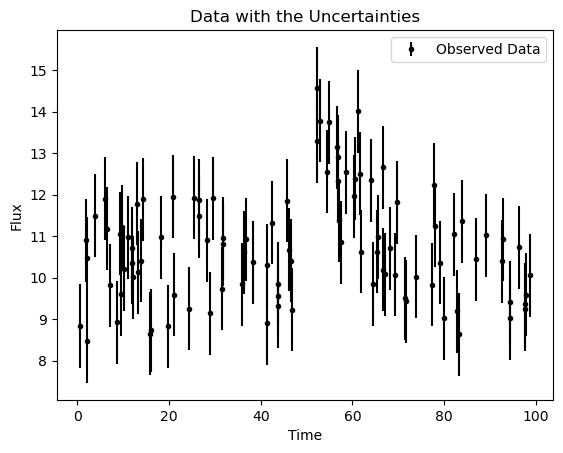

In [2]:
#Part.1
#Plotting the data with uncertainties 

#Setting time,flux, flux uncertainties to data 
time, flux, flux_uncert = data.T

#Plotting data with uncertainties
plt.errorbar(time, flux, flux_uncert, fmt=".k", label="Observed Data")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title ("Data with the Uncertainties")
plt.legend()
plt.show()

In [5]:
pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Part.2
#Definintion onf Burst Model

def bur_mod(theta,t):
    b,A,t0,alpha=theta
    y= np.where(t<t0,b,b + A* np.exp(-alpha * (t-t0)))
    return y
    
#Definition of the likelihood function

def log_likie(theta, t, y,flux_uncert ):
    model = bur_mod(theta, t)
    return -0.5 * np.sum(((y - model) / flux_uncert) ** 2)
    
#Definition of Log_Prior

def log_pri(theta):
    b, A, t0, log_alpha = theta
    alpha = np.exp(log_alpha)
    if 0 <= b <= 50 and 0 <= A <= 50 and 0 <= t0 <= 100 and -5 <= log_alpha <= 5:
        return 0.0
    return -np.inf

#Definition of Log Probability

def log_prob(theta, t, y, flux_uncert):
    lp = log_pri(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likie(theta, t, y, flux_uncert)


In [4]:
#Part.3

from tqdm import tqdm

ndim = 4
nwalkers = 32
nsteps = 5000

initial = np.array([25, 25, 50, 0]) + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, flux, flux_uncert))#yerr=flux_uncert

for _ in tqdm(range(nsteps), desc="Running MCMC"):
    sampler.run_mcmc(initial, 1, progress=False) 

Running MCMC: 100%|███████████████████████| 5000/5000 [00:04<00:00, 1006.01it/s]


In [9]:
#Part.4
#MCMC Chain Processing
#autocorrelation length as requested in part 4 of the problem.

burn=1000

Auto_corr = sampler.get_autocorr_time(tol=0)
max_auto_corr = int(np.max(Auto_corr)) 
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
flt_samp = samples.copy()

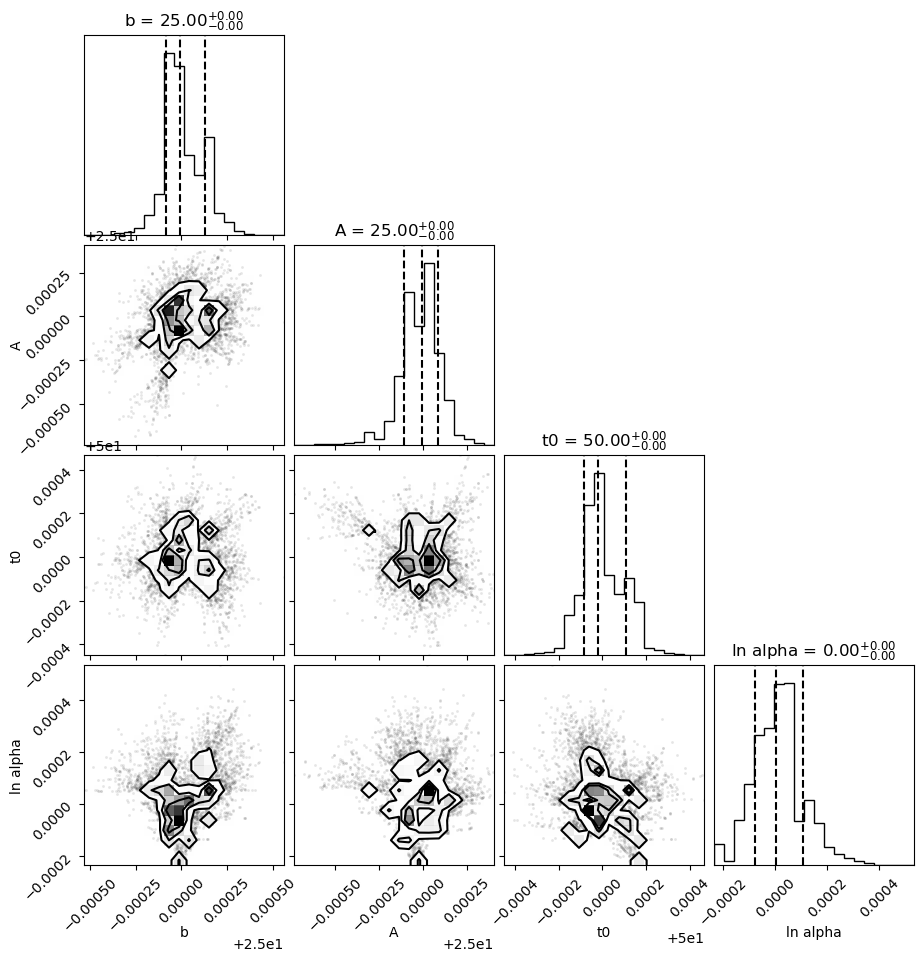

In [7]:
#Part.5
#Plotiing the Corner Plot
#import corner to do plots

import corner

#corner plot of the 4-D parameter space, with labels, [68,95]% credible levels and quantiles, and titles.

fig = corner.corner(samples, labels=["b", "A", "t0", "ln alpha"], quantiles=[0.16, 0.5, 0.84], show_titles=True)
plt.show()


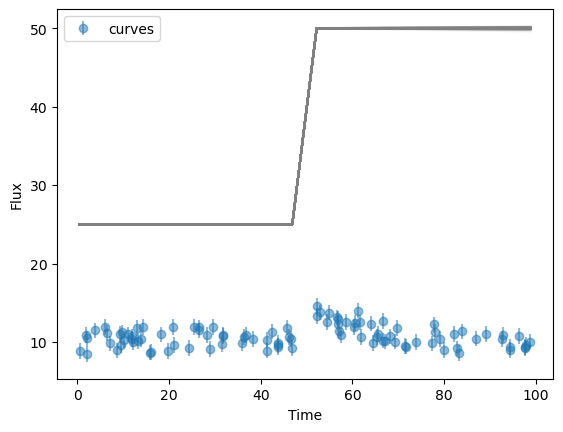

In [13]:
#Part.6
#choose 100 samples randomly from your burned
#thinned chain and plot the 100 corresponding burst time-series


plt.errorbar(time, flux, flux_uncert, fmt='o', label='curves', alpha=0.5)
for sample in flt_samp[np.random.randint(len(flt_samp), size=100)]:
    
    plt.plot(time, bur_mod(sample, time), color="gray", alpha=0.1)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

In [83]:
pip install dynesty


Note: you may need to restart the kernel to use updated packages.


In [23]:
#Part.7

import dynesty
from dynesty import NestedSampler

# Define the Gaussian model function
def gauss_modl(theta, t):
    theta = np.atleast_1d(theta)  # Ensure theta is an array
    if len(theta) != 4:
        raise ValueError(f"Expected theta to have 4 parameters, but got {theta}")

    b, A, t0, log_sigma_w = theta
    sigma_w = np.exp(log_sigma_w)
    return b + A * np.exp(-((t - t0) ** 2) / (2 * sigma_w ** 2))

# Define the log-likelihood function
def log_likie_gauss(theta, t, y, yerr):
    theta = np.atleast_1d(theta)  # Ensure theta is an array
    model = gaussian_model(theta, t)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

# Define the log-prior function
def log_pri_gauss(theta):
    theta = np.atleast_1d(theta)  # Ensure theta is an array
    if len(theta) != 4:
        return -np.inf  # Invalid parameter set
    
    b, A, t0, log_sigma_w = theta
    if not (-10 < b < 10 and 0 < A < 10 and 0 < t0 < 100 and -5 < log_sigma_w < 5):
        return -np.inf  # Reject values outside reasonable bounds
    return 0  # Uniform prior



The above code (part.7) is incomplete I gave it my best shot, however the last part of the code kept returning errors and debugging was terrible.